In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Input, Dropout, Activation
from keras.models import Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
import time
import tqdm
import random
from bayes_opt import BayesianOptimization

Using TensorFlow backend.


Load and clean the data.

In [29]:
data = pd.read_csv('final_data.csv')
# Convert labels
data.loc[data.CONT == "NO","CONT"] = -1
data.loc[data.CONT != -1,"CONT"] = 1
# Subset columns
cols = ["BUN","CA","CL","CO2","CRET","GLU","K","NA.","CONT"]
data = data[cols]
# Banish negativity :)
data.loc[data.CA < 0,"CA"] = 0
# Convert to int.  Could save space with binary, but meh...
data.CONT = data.CONT.astype("int64")
# Drop NAs
data = data.dropna()
# To numpy, Batman!
data = data.as_matrix()
# Normalize features
num_features = len(cols)-1
means = np.zeros(num_features)
stds = np.zeros(num_features)
for x in range(data.shape[1]-1):
    means[x] = data[:,x].mean()
    stds[x] = data[:,x].std()
# Split
test_samples = int(.2*len(data))
np.random.shuffle(data)
test = data[:test_samples,:]
train = data[test_samples:,:]
# Labels
train_samples = len(train)
labels = np.array([1]*train_samples)

Build the generator.

In [30]:
def build_gen(learning_rate=1e-3):
    opt = Adam(lr = learning_rate)
    input = Input(shape = (9,))
    G = Dropout(.2)(input)
    G = Dense(64)(G)
    G = Activation('relu')(G)
    G = Dropout(.2)(G)
    G = Dense(32)(G)
    G = Activation('relu')(G)
    G = Dropout(.2)(G)
    sample = Dense(9)(G)
    generator = Model(input = input, output = sample)
    generator.compile(loss = 'binary_crossentropy', optimizer = opt)
    return generator

Build the discriminator.

In [31]:
def build_dis(learning_rate = 1e-3):
    dinput = Input(shape = (9,))
    D = Dropout(.2)(dinput)
    D = Dense(64)(D)
    D = Activation('relu')(D)
    D = Dropout(.2)(D)
    D = Dense(32)(D)
    D = Activation('relu')(D)
    D = Dropout(.2)(D)
    pred = Dense(1,activation = 'sigmoid')(D)
    discriminator = Model(input = dinput, output = pred)
    discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(lr=learning_rate))
    return discriminator

In [32]:
generator = build_gen()
discriminator = build_dis()

Freeze discriminator.

In [33]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val

Stack models.

In [34]:
def build_gan(generator=generator, discriminator=discriminator, learning_rate=1e-3):
    gan_in = Input(shape = (9,))
    T = generator(gan_in)
    gan_out = discriminator(T)
    gan = Model(input = gan_in, output = gan_out)
    gan.compile(loss = 'binary_crossentropy', optimizer = Adam(lr=learning_rate))
    return gan

In [35]:
gan = build_gan()

Pretrain the discriminator.

In [42]:
def pretrain(generator,discriminator, nb_epoch=10):
    # Generate data
    ndata = np.random.randn(train_samples, num_features)
    p = sum(train[train[:,8] > 0, 8])/len(train)
    CONT = np.random.choice([-1,1], train_samples, p = [1-p,p])
    fdata = np.concatenate((ndata,CONT[:,None]), axis=1)
    gen_data = generator.predict(fdata)
    X = np.concatenate((train,gen_data))
    y = np.zeros(2*train_samples)
    y[:train_samples] = 1
    make_trainable(discriminator,True)
    discriminator.fit(X,y,nb_epoch=nb_epoch,batch_size=len(X))
    y_hat = discriminator.predict(X)
    y_hat[y_hat>=.5] = 1
    y_hat[y_hat<.5] = 0
    print "Accuracy: {}".format(1-np.abs(y - y_hat).sum()/float(len(y)))

Prepare loss storage for plots.

In [43]:
losses = {'d':[],'g':[]}

The main event.

In [44]:
def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()
        
def batch_training(nb_epoch=500,plt_freq=10,batch_size=len(train),
                  h_thresh=.8,l_thresh=.45,handicap=4):
    for i in tqdm.tqdm(range(nb_epoch)):
        # Make generated data
        real_batch = train[np.random.randint(0,train.shape[0],size=batch_size),:]
        noise = np.random.randn(batch_size, num_features)
        CONT = np.random.choice([-1,1], batch_size, p = [1-p,p])
        noise_tot = np.concatenate((noise,CONT[:,None]), axis=1)
        fake_batch = generator.predict(noise_tot)
        
        d_loss=None
        g_loss=None
        # Train discriminator
        #if (d_loss and g_loss and g_loss<h_thresh and d_loss>l_thresh) or i==1:
        X = np.concatenate((real_batch,fake_batch))
        y = np.zeros(2*batch_size)
        y[:batch_size]=1
        make_trainable(discriminator,True)
        d_loss = discriminator.train_on_batch(X,y)
        if d_loss:
            losses['d'].append(d_loss)
        
        # Train stack
        for i in range(handicap):
            noise = np.random.randn(batch_size, num_features)
            CONT = np.random.choice([-1,1], batch_size, p = [1-p,p])
            noise_tot = np.concatenate((noise,CONT[:,None]), axis=1)
            y = np.zeros(batch_size)
            make_trainable(discriminator,False)
            g_loss = gan.train_on_batch(noise_tot,y)
        if d_loss:
            losses['g'].append(g_loss)
        
        if i % plt_freq==plt_freq-1:
            plot_loss(losses)
            
def measure(generator,discriminator):
    ndata = np.random.randn(test_samples, num_features)
    p = sum(test[test[:,8] > 0, 8])/len(test)
    CONT = np.random.choice([-1,1], test_samples, p = [1-p,p])
    fdata = np.concatenate((ndata,CONT[:,None]), axis=1)
    samples = generator.predict(fdata)
    return np.square(np.add(discriminator.predict(np.concatenate((test,samples))),-.5)).mean()

In [45]:
ndata = np.random.randn(train_samples, num_features)
p = sum(train[train[:,8] > 0, 8])/len(train)
CONT = np.random.choice([-1,1], train_samples, p = [1-p,p])
fdata = np.concatenate((ndata,CONT[:,None]), axis=1)
gen_data = generator.predict(fdata)

In [46]:
measurable_fn()

Epoch 1/50
22312/22312 [==============================] - 0s - loss: 3.4153
Epoch 2/50
22312/22312 [==============================] - 0s - loss: 2.8563
Epoch 3/50
22312/22312 [==============================] - 0s - loss: 2.2226
Epoch 4/50
22312/22312 [==============================] - 0s - loss: 1.6996
Epoch 5/50
22312/22312 [==============================] - 0s - loss: 1.3702
Epoch 6/50
22312/22312 [==============================] - 0s - loss: 1.0212
Epoch 7/50
22312/22312 [==============================] - 0s - loss: 0.8525
Epoch 8/50
22312/22312 [==============================] - 0s - loss: 0.6943
Epoch 9/50
22312/22312 [==============================] - 0s - loss: 0.5724
Epoch 10/50
22312/22312 [==============================] - 0s - loss: 0.4958
Epoch 11/50
22312/22312 [==============================] - 0s - loss: 0.4554
Epoch 12/50
22312/22312 [==============================] - 0s - loss: 0.4215
Epoch 13/50
22312/22312 [==============================] - 0s - loss: 0.4082
Epoch 14


  0%|          | 0/250 [00:00<?, ?it/s]

Accuracy: -11155.0



  6%|▋         | 16/250 [00:05<01:31,  2.56it/s]

  7%|▋         | 17/250 [00:06<01:29,  2.61it/s]Exception in thread Thread-16:
Traceback (most recent call last):
  File "/Users/jasonmancuso/anaconda/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/Users/jasonmancuso/anaconda/lib/python2.7/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/jasonmancuso/anaconda/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


100%|██████████| 250/250 [01:29<00:00,  2.71it/s]


-0.13329846

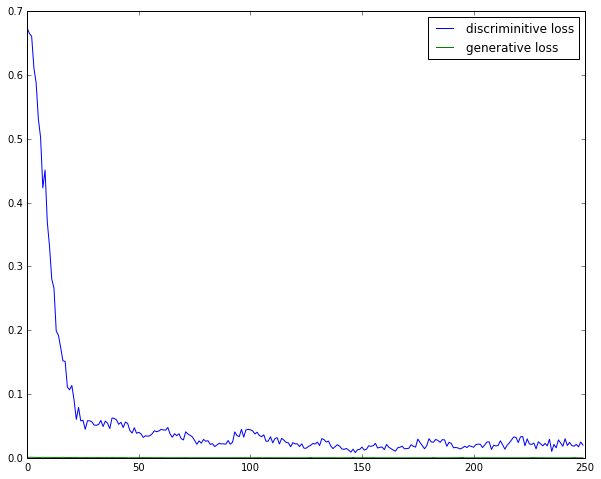

In [47]:
plot_loss(losses)

In [12]:
def measurable_fn(lr_g=1e-3,lr_d=1e-3,lr_gan=1e-4,pretrain_epoch=50,training_epoch=250):
    generator = build_gen(learning_rate=lr_g)
    discriminator = build_dis(learning_rate=lr_d)
    gan = build_gan(learning_rate=lr_gan)
    pretrain(generator,discriminator,nb_epoch=pretrain_epoch)
    batch_training(nb_epoch=training_epoch,plt_freq=10)
    return -measure(generator,discriminator)

In [ ]:
paramdict={'lr_d':(1e-4,1e-3),'lr_gan':(1e-3,.01)}
bo = BayesianOptimization(measurable_fn,paramdict)

In [ ]:
bo.maximize(init_points=3,n_iter=47,acq='ei')

In [48]:
ndata = np.random.randn(train_samples, num_features)
p = sum(train[train[:,8] > 0, 8])/len(train)
CONT = np.random.choice([-1,1], train_samples, p = [1-p,p])
fdata = np.concatenate((ndata,CONT[:,None]), axis=1)
samples = generator.predict(fdata)
unnormalized=np.zeros(samples.shape)
for x in range(samples.shape[1]-2):
    unnormalized[:,x] = np.add(np.multiply(samples[:,x],stds[x]),means[x])
unnormalized[:,8] = samples[:,8]

array([ 5.74729395,  5.84382534,  5.4915967 , ...,  7.42720556,
        4.07185364,  5.43231869], dtype=float32)

In [ ]:
data_un = pd.read_csv('final_data.csv')
# Convert labels
data_un.loc[data_un.CONT == "NO","CONT"] = -1
data_un.loc[data_un.CONT != -1,"CONT"] = 1
# Subset columns
cols = ["BUN","CA","CL","CO2","CRET","GLU","K","NA.","CONT"]
data_un = data_un[cols]
# Banish negativity :)
data_un.loc[data_un.CA < 0,"CA"] = 0
# Convert to int.  Could save space with binary, but meh...
data_un.CONT = data_un.CONT.astype("int64")
# Drop NAs
data_un = data_un.dropna()
# To numpy, Batman!
data_un = data_un.as_matrix()
print means
print unnormalized[1000]

In [ ]:
unnormalized[unnormalized[:,-1]>.4].shape

In [ ]:
CONT[CONT>0].shape